<a href="https://colab.research.google.com/github/adrincont/Tareas_UNAL/blob/main/Regresion%20(Modelo%20clase%201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Librerias
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.0


In [2]:
# Descargar los datos
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

40960/30286 [========================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

In [8]:
# Ponemos los nombres de las columnas, leemos el archivo de datos
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy() # Copia de los datos
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Preprocesamiento

In [9]:
# Detecta datos faltantes y elimina filas. El set de datos contiene algunos valores desconocidos.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
dataset = dataset.dropna()

## Codificación one-hot

In [11]:
# La columna de "Origin" realmente es categorica, no numerica. Entonces conviertala a un "one-hot" (tres columnas):
# retira 'Origin' de dataset y lo entrega. Se recibe en la variable origin
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Dividir los datos en entrenamiento y test

In [13]:
# Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.
# Usaremos el set de pruebas en la evaluacion final de nuestro modelo.
train_dataset = dataset.sample(frac=0.8,random_state=0) # me aseguro que los mezclo y tomo una muesta del 80% con semilla
test_dataset = dataset.drop(train_dataset.index)
train_dataset.keys()

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

# Descriptivo de los datos¶

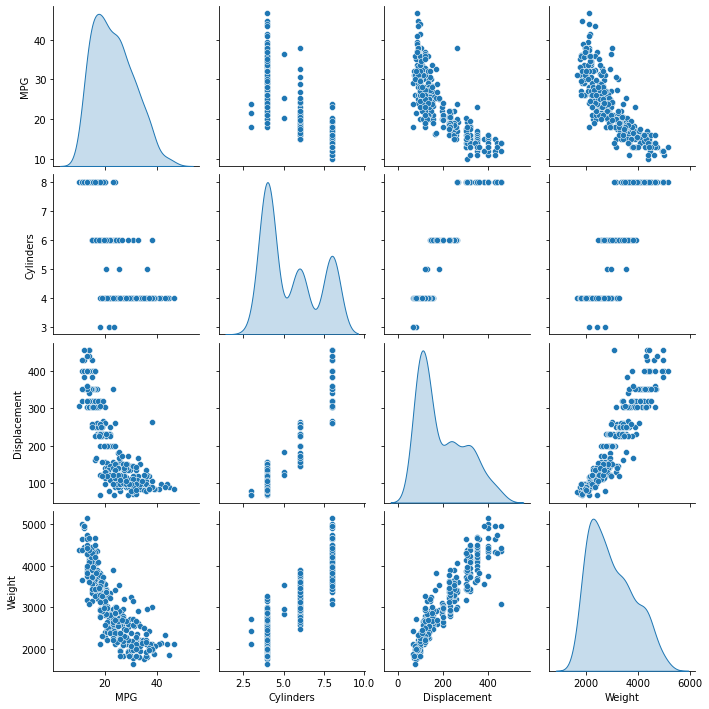

In [14]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [15]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## Separe caracteristicas y etiquetas

In [16]:
# Separe el valor objetivo, o la "etiqueta" de las caracteristicas. Esta etiqueta es el valor que entrenara el modelo para predecir.
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## Normalice los datos

In [17]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

**Precaución:**
Las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

# Construye el modelo Sequential modo 1 (Modelo 1)
Construyamos nuestro modelo. Aquí, utilizaremos un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, build_model, ya que crearemos un segundo modelo, más adelante.

In [18]:
# Constrir un modelo de forma secuencial
# Definiendo capa a capa del modelo, con las caracteristicas de las capas como 
# funciones de activacion
model = keras.Sequential([ # Entran 9 variables
# Primera capa: 9 (variables) --> 64, relu(.), input_shape (tamaño de entrada)
layers.Dense(64, activation='relu', input_shape=(normed_train_data.shape[1],)),
# Segunda capa: 64 --> 64, relu(.)
layers.Dense(64, activation='relu'),
# Tercera capa: 64 --> 1, resultado final
layers.Dense(1)
])
# Notas:
# -> Cantidad de capas: colocar en un espacio al inicio mas grande para que se 
#    separen las caracteristicas (potencias de 2) 16-32-64 ...
# -> la salida depende del problema.
# -> Organiza los datos de tal manera que que se clusterizan 
#    (las capas permiten proyectar en nuevos espacios).

## Compila

In [19]:
# definimos el optimizador (recomendado Adam)
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', # Funcion de perdida (optimizar)
                optimizer=optimizer,
                metrics=['mae', 'mse'] # para ver como va el proceso
              )
# model.compile: alista el modelo para los calculos

In [22]:
model.summary()
# Primera capa: (None, 64) (lotes de 1) (9 + 1) * 64
# Segunda capa: (None, 64)
# Tercera capa: (None, 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento
Entrene el modelo durante 1000 epochs y registre la precisión de entrenamiento y validación en el objeto history.

In [23]:
# Display training progress by printing a single dot for each completed epoch
# Especie de callback para imprimir puntitos a medida que entrena
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [24]:
epochs = 1000

history = model.fit(
  normed_train_data, train_labels, # datos del modelo
  epochs=epochs, # Numero de epocas
  validation_split = 0.2, # separe 20% para validacion interna
  verbose=0, # Que quiero que implrima
  callbacks=[PrintDot()] # Ejecute el callback que programamos
  )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [25]:
# Resumen del modelo
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.017693,1.096584,3.017693,9.542670,2.286683,9.542670,995
996,2.722942,1.051087,2.722942,9.298108,2.246322,9.298108,996
997,2.790538,1.091223,2.790538,9.678242,2.330969,9.678242,997
998,2.765187,1.059768,2.765187,9.833111,2.279540,9.833111,998
999,2.826394,1.062482,2.826394,9.675139,2.266958,9.675139,999


Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada model.fit para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una devolución de llamada de EarlyStopping que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

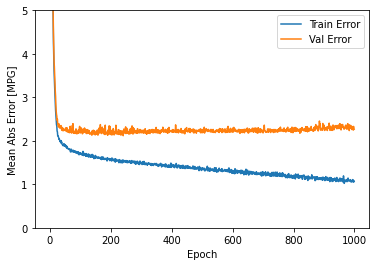

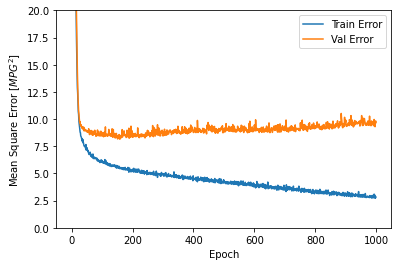

In [26]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

# -> Grafico de la evolucion de las metricas, la perdida de entrenamiento desende pero para validacion se aumento luego
#    llamamos a este problema sobre ajuste, puedo quedarme antes del problema, puede ser problema de la rata de aprendizaje


...............

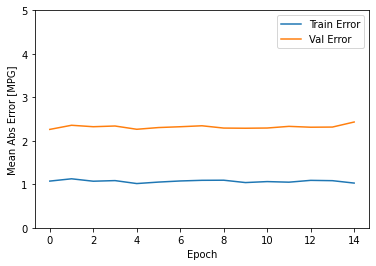

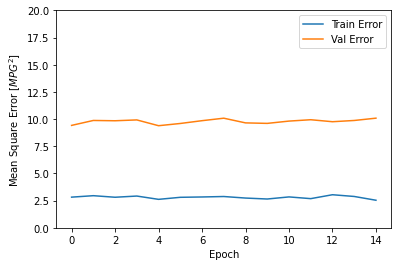

In [27]:
# Colocar otro callback, para que se detenga prematuramente cuando la perdida no baje mas
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Veamos qué tan bien generaliza el modelo al usar el conjunto test , que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.5851 - mae: 2.1016 - mse: 7.5851 - 22ms/epoch - 7ms/step
Testing set Mean Abs Error:  2.10 MPG


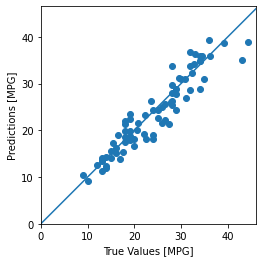

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])